<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in New York City</font></h1>


## Introduction

In this lab, you will learn how to convert addresses into their equivalent latitude and longitude values. Also, you will use the Foursquare API to explore neighborhoods in New York City. You will use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. You will use the _k_-means clustering algorithm to complete this task. Finally, you will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters.


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Download and Explore Dataset</a>

2.  <a href="#item2">Explore Neighborhoods in New York City</a>

3.  <a href="#item3">Analyze Each Neighborhood</a>

4.  <a href="#item4">Cluster Neighborhoods</a>

5.  <a href="#item5">Examine Clusters</a>  
    </font>
    </div>


Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    openssl-1.1.1k             |       h7f98852_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.3 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be UPDATED:

  certifi                          2020.12.5-py

<a id='item1'></a>


## 1. Download and Explore Dataset


Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 


For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.


In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data


Next, let's load the data.


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.


In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the _features_ key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.


In [7]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.


In [8]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a _pandas_ dataframe


The next task is essentially transforming this data of nested Python dictionaries into a _pandas_ dataframe. So let's start by creating an empty dataframe.


In [9]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.


In [10]:
neighborhoods

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

Then let's loop through the data and fill the dataframe one row at a time.


In [11]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.


In [12]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.


In [13]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.


In [14]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.


In [15]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,x
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.


However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.


In [16]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

Borough        Neighborhood   Latitude  Longitude
0  Manhattan         Marble Hill  40.876551 -73.910660
1  Manhattan           Chinatown  40.715618 -73.994279
2  Manhattan  Washington Heights  40.851903 -73.936900
3  Manhattan              Inwood  40.867684 -73.921210
4  Manhattan    Hamilton Heights  40.823604 -73.949688

Let's get the geographical coordinates of Manhattan.


In [17]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.


In [18]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

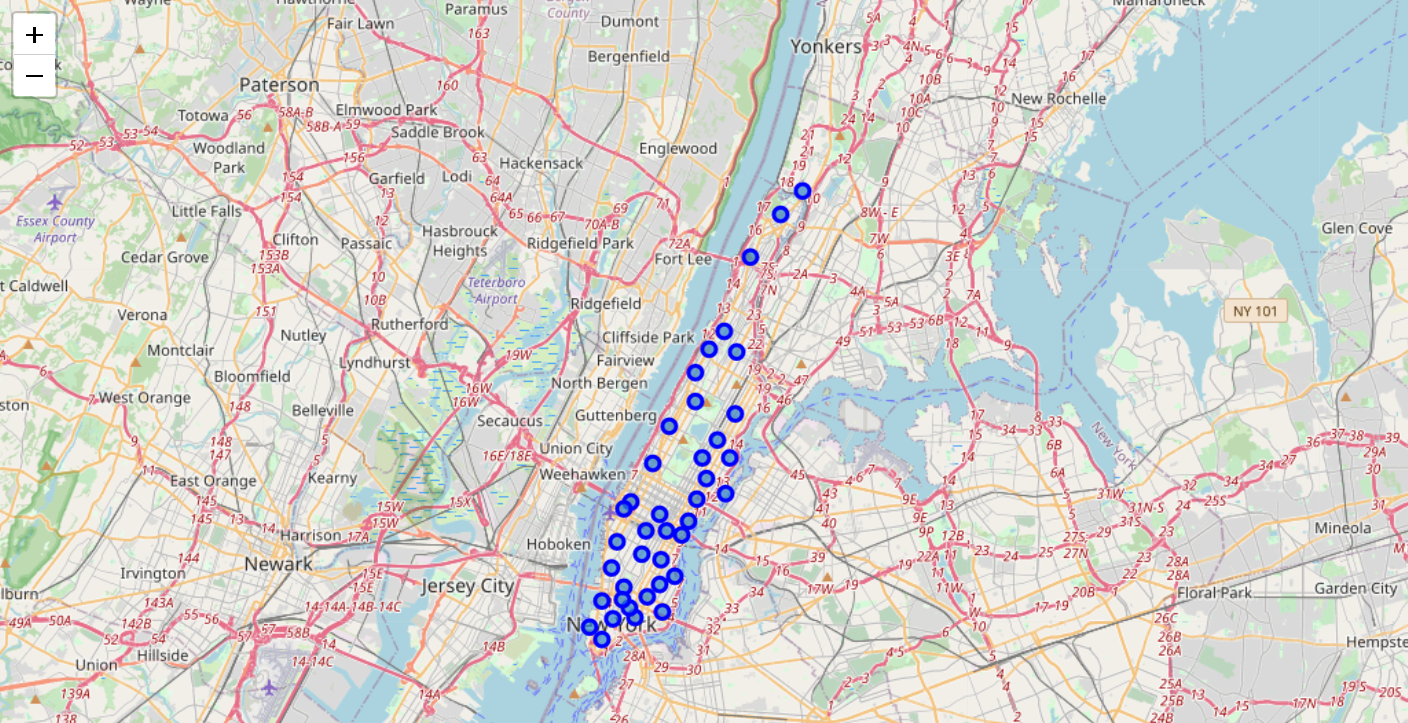Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


#### Define Foursquare Credentials and Version


In [19]:
CLIENT_ID = 'PRGJP2KTHQJW2GSA1O4BJC1UTQCBLQ5SPTGOAH4BN3TXAUAF' # your Foursquare ID
CLIENT_SECRET = 'A4V0FBT01TBMDP4E24R52W2K3SYQNZF023AT1ZGV0D2MCZ3X' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PRGJP2KTHQJW2GSA1O4BJC1UTQCBLQ5SPTGOAH4BN3TXAUAF
CLIENT_SECRET:A4V0FBT01TBMDP4E24R52W2K3SYQNZF023AT1ZGV0D2MCZ3X


#### Let's explore the first neighborhood in our dataframe.


Get the neighborhood's name.


In [20]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.


In [21]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.


First, let's create the GET request URL. Name your URL **url**.


In [22]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=PRGJP2KTHQJW2GSA1O4BJC1UTQCBLQ5SPTGOAH4BN3TXAUAF&client_secret=A4V0FBT01TBMDP4E24R52W2K3SYQNZF023AT1ZGV0D2MCZ3X&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

Double-click **here** for the solution.

<!-- The correct answer is:
LIMIT = 100 # limit of number of venues returned by Foursquare API
-->

<!--
radius = 500 # define radius
-->

<!--
\\\\ # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL
--> 


Send the GET request and examine the resutls


In [23]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6067282d86e3eb7bf0c719e0'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Marble Hill',
  'headerFullLocation': 'Marble Hill, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 22,
  'suggestedBounds': {'ne': {'lat': 40.88105078329964,
    'lng': -73.90471933917806},
   'sw': {'lat': 40.87205077429964, 'lng': -73.91659997808156}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4429abf964a52037f225e3',
       'name': "Arturo's",
       'location': {'address': '5198 Broadway',
        'crossStreet': 'at 225th St.',
        'lat': 40.87441177110231,
        'lng': -73.91027100981574,
        'labeledLatLngs': [{'label'

From the Foursquare lab in the previous module, we know that all the information is in the _items_ key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.


In [24]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.


In [25]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


name   categories        lat        lng
0                          Arturo's  Pizza Place  40.874412 -73.910271
1                       Bikram Yoga  Yoga Studio  40.876844 -73.906204
2                     Tibbett Diner        Diner  40.880404 -73.908937
3                           Dunkin'   Donut Shop  40.877136 -73.906666
4  Astral Fitness & Wellness Center          Gym  40.876705 -73.906372

And how many venues were returned by Foursquare?


In [26]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

22 venues were returned by Foursquare.


<a id='item2'></a>


## 2. Explore Neighborhoods in Manhattan


#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan


In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _manhattan_venues_.


In [30]:
# type your answer here
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Double-click **here** for the solution.

<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 


#### Let's check the size of the resulting dataframe


In [31]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3237, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Marble Hill              40.876551               -73.91066   
1  Marble Hill              40.876551               -73.91066   
2  Marble Hill              40.876551               -73.91066   
3  Marble Hill              40.876551               -73.91066   
4  Marble Hill              40.876551               -73.91066   

                              Venue  Venue Latitude  Venue Longitude  \
0                          Arturo's       40.874412       -73.910271   
1                       Bikram Yoga       40.876844       -73.906204   
2                     Tibbett Diner       40.880404       -73.908937   
3                           Dunkin'       40.877136       -73.906666   
4  Astral Fitness & Wellness Center       40.876705       -73.906372   

  Venue Category  
0    Pizza Place  
1    Yoga Studio  
2          Diner  
3     Donut Shop  
4            Gym

Let's check how many venues were returned for each neighborhood


In [32]:
manhattan_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                
Battery Park City                       78                      78     78   
Carnegie Hill                           96                      96     96   
Central Harlem                          45                      45     45   
Chelsea                                100                     100    100   
Chinatown                              100                     100    100   
Civic Center                           100                     100    100   
Clinton                                100                     100    100   
East Harlem                             37                      37     37   
East Village                           100                     100    100   
Financial District                     100                     100    100   
Flatiron                               100                     100    100   
Gramercy                                94                      94     94   
Greenwich Village                      100                     100    100   
Hamilton Heights                        62                      62     62   
Hudson Yards                            72                      72     72   
Inwood                                  55                      55     55   
Lenox Hill                             100                     100    100   
Lincoln Square                          94                      94     94   
Little Italy                           100                     100    100   
Lower East Side                         49                      49     49   
Manhattan Valley                        49                      49     49   
Manhattanville                          45                      45     45   
Marble Hill                             22                      22     22   
Midtown                                100                     100    100   
Midtown South                          100                     100    100   
Morningside Heights                     41                      41     41   
Murray Hill                            100                     100    100   
Noho                                   100                     100    100   
Roosevelt Island                        28                      28     28   
Soho                                   100                     100    100   
Stuyvesant Town                         19                      19     19   
Sutton Place                           100                     100    100   
Tribeca                                 87                      87     87   
Tudor City                              78                      78     78   
Turtle Bay                             100                     100    100   
Upper East Side                        100                     100    100   
Upper West Side                         99                      99     99   
Washington Heights                      87                      87     87   
West Village                           100                     100    100   
Yorkville                              100                     100    100   

                     Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                          
Battery Park City                78               78              78  
Carnegie Hill                    96               96              96  
Central Harlem                   45               45              45  
Chelsea                         100              100             100  
Chinatown                       100              100             100  
Civic Center                    100              100             100  
Clinton                         100              100             100  
East Harlem                      37               37              37  
East Village                    100              100             100  
Finan

#### Let's find out how many unique categories can be curated from all the returned venues


In [33]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 331 uniques categories.


<a id='item3'></a>


## 3. Analyze Each Neighborhood


In [38]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0  Marble Hill                  0               0                  0   
1  Marble Hill                  0               0                  0   
2  Marble Hill                  0               0                  0   
3  Marble Hill                  0               0                  0   
4  Marble Hill                  0               0                  0   

   African Restaurant  American Restaurant  Antique Shop  Arepa Restaurant  \
0                   0                    0             0                 0   
1                   0                    0             0                 0   
2                   0                    0             0                 0   
3                   0                    0             0                 0   
4                   0                    0             0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auditorium  Australian Restaurant  \
0                 0                   0           0                      0   
1                 0                   0           0                      0   
2                 0                   0           0                      0   
3                 0                   0           0                      0   
4                 0                   0           0                      0   

   Austrian Restaurant  Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  \
0                    0              0          0           0           0   
1                    0              0          0           0           0   
2                    0              0          0           0           0   
3                    0              0          0           0           0   
4                    0              0          0           0           0   

   Bakery  Bank  Bar  Baseball Field  Basketball Court  Beer Bar  Beer Garden  \
0       0     0    0               0                 0         0            0   
1       0     0    0               0                 0         0            0   
2       0     0    0               0                 0         0            0   
3       0     0    0               0                 0         0            0   
4       0     0    0               0                 0         0            0   

   Beer Store  Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  \
0           0              0                         0          0           0   
1           0              0                         0          0           0   
2           0              0                         0          0           0   
3           0              0                         0          0           0   
4           0              0                         0          0           0   

   Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  Boxing Gym  \
0       0           0              0          0         0           0   
1       0           0              0          0         0           0   
2       0           0              0          0         0           0   
3       0           0              0          0         0           0   
4       0           0              0          0         0           0   

   Brazilian Restaurant  Breakfast Spot  Bridal Shop  Bridge  Bubble Tea Shop  \
0                     0               0            0       0                0   
1                     0               0            0       0                0   
2                     0               0            0       0       

And let's examine the new dataframe size.


In [36]:
manhattan_onehot.shape

(3237, 332)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [37]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0     Battery Park City           0.000000        0.000000               0.00   
1         Carnegie Hill           0.000000        0.000000               0.00   
2        Central Harlem           0.000000        0.000000               0.00   
3               Chelsea           0.000000        0.000000               0.00   
4             Chinatown           0.000000        0.000000               0.00   
5          Civic Center           0.000000        0.000000               0.00   
6               Clinton           0.000000        0.000000               0.00   
7           East Harlem           0.000000        0.000000               0.00   
8          East Village           0.000000        0.000000               0.00   
9    Financial District           0.010000        0.000000               0.00   
10             Flatiron           0.000000        0.000000               0.00   
11             Gramercy           0.000000        0.000000               0.00   
12    Greenwich Village           0.010000        0.000000               0.00   
13     Hamilton Heights           0.000000        0.016129               0.00   
14         Hudson Yards           0.000000        0.000000               0.00   
15               Inwood           0.000000        0.000000               0.00   
16           Lenox Hill           0.000000        0.000000               0.01   
17       Lincoln Square           0.000000        0.000000               0.00   
18         Little Italy           0.000000        0.000000               0.00   
19      Lower East Side           0.000000        0.000000               0.00   
20     Manhattan Valley           0.000000        0.000000               0.00   
21       Manhattanville           0.000000        0.000000               0.00   
22          Marble Hill           0.000000        0.000000               0.00   
23              Midtown           0.000000        0.000000               0.00   
24        Midtown South           0.000000        0.000000               0.00   
25  Morningside Heights           0.000000        0.000000               0.00   
26          Murray Hill           0.000000        0.000000               0.00   
27                 Noho           0.000000        0.000000               0.00   
28     Roosevelt Island           0.000000        0.000000               0.00   
29                 Soho           0.000000        0.000000               0.00   
30      Stuyvesant Town           0.000000        0.000000               0.00   
31         Sutton Place           0.000000        0.010000               0.00   
32              Tribeca           0.000000        0.000000               0.00   
33           Tudor City           0.000000        0.000000               0.00   
34           Turtle Bay           0.000000        0.000000               0.00   
35      Upper East Side           0.000000        0.000000               0.00   
36      Upper West Side           0.010101        0.000000               0.00   
37   Washington Heights           0.011494        0.000000               0.00   
38         West Village           0.010000        0.000000               0.00   
39            Yorkville           0.000000        0.000000               0.00   

    African Restaurant  American Restaurant  Antique Shop  Arepa Restaurant  \
0             0.000000             0.012821          0.00          0.000000   
1             0.000000             0.010417          0.00          0.000000   
2             0.066667             0.044444          0.00          0.000000   
3             0.000000             0.040000          0.00          0.000000   
4             0.000000             0.040000          0.00          0.000000   
5             0.000000             0.040000          0.01          0.000000   
6             0.000000             0.040000          0.00          0.000000   
7             0.000000             0.000000          0.00

#### Let's confirm the new size


In [39]:
manhattan_grouped.shape

(40, 332)

#### Let's print each neighborhood along with the top 5 most common venues


In [40]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
            venue  freq
0            Park  0.10
1  Clothing Store  0.05
2             Gym  0.05
3     Coffee Shop  0.05
4   Memorial Site  0.04


----Carnegie Hill----
         venue  freq
0  Coffee Shop  0.07
1         Café  0.06
2          Bar  0.04
3  Yoga Studio  0.03
4  Pizza Place  0.03


----Central Harlem----
                  venue  freq
0    African Restaurant  0.07
1    Seafood Restaurant  0.04
2           Art Gallery  0.04
3  Gym / Fitness Center  0.04
4     French Restaurant  0.04


----Chelsea----
                venue  freq
0         Coffee Shop  0.07
1         Art Gallery  0.05
2              Bakery  0.04
3  Italian Restaurant  0.04
4   French Restaurant  0.04


----Chinatown----
                 venue  freq
0   Chinese Restaurant  0.09
1               Bakery  0.07
2         Cocktail Bar  0.05
3  American Restaurant  0.04
4    Hotpot Restaurant  0.04


----Civic Center----
                 venue  freq
0          Coffee Shop  0.07
1             

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Battery Park City                  Park           Coffee Shop   
1      Carnegie Hill           Coffee Shop                  Café   
2     Central Harlem    African Restaurant  Gym / Fitness Center   
3            Chelsea           Coffee Shop           Art Gallery   
4          Chinatown    Chinese Restaurant                Bakery   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0        Clothing Store                   Gym                 Hotel   
1                   Bar           Yoga Studio             Bookstore   
2                   Bar   American Restaurant     French Restaurant   
3                Bakery    Italian Restaurant   American Restaurant   
4          Cocktail Bar     Hotpot Restaurant   American Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0         Memorial Site    Italian Restaurant            Playground   
1        Cosmetics Shop           Pizza Place     French Restaurant   
2    Seafood Restaurant           Art Gallery    Chinese Restaurant   
3     French Restaurant                 Hotel             Wine Shop   
4          Dessert Shop                   Spa    Salon / Barbershop   

  9th Most Common Venue 10th Most Common Venue  
0                 Plaza         Sandwich Place  
1                   Gym              Wine Shop  
2        Cosmetics Shop              Bookstore  
3        Ice Cream Shop                   Park  
4          Optical Shop        Bubble Tea Shop

<a id='item4'></a>


## 4. Cluster Neighborhoods


Run _k_-means to cluster the neighborhood into 5 clusters.


In [43]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 4, 4, 4, 1, 1, 0, 4, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [44]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

Borough        Neighborhood   Latitude  Longitude  Cluster Labels  \
0  Manhattan         Marble Hill  40.876551 -73.910660               1   
1  Manhattan           Chinatown  40.715618 -73.994279               4   
2  Manhattan  Washington Heights  40.851903 -73.936900               2   
3  Manhattan              Inwood  40.867684 -73.921210               0   
4  Manhattan    Hamilton Heights  40.823604 -73.949688               0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                   Gym           Coffee Shop        Sandwich Place   
1    Chinese Restaurant                Bakery          Cocktail Bar   
2                  Café                Bakery     Mobile Phone Shop   
3    Mexican Restaurant            Restaurant                  Café   
4           Pizza Place                  Café           Coffee Shop   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0           Yoga Studio        Tennis Stadium            Kids Store   
1     Hotpot Restaurant   American Restaurant          Dessert Shop   
2                  Bank    Chinese Restaurant         Grocery Store   
3                 Diner                  Park           Pizza Place   
4    Mexican Restaurant         Deli / Bodega           Yoga Studio   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Donut Shop        Discount Store                 Diner   
1                   Spa    Salon / Barbershop          Optical Shop   
2       Supplement Shop    Spanish Restaurant           Pizza Place   
3    Chinese Restaurant                Bakery  Caribbean Restaurant   
4      Sushi Restaurant  Caribbean Restaurant                School   

      10th Most Common Venue  
0           Department Store  
1            Bubble Tea Shop  
2  Latin American Restaurant  
3                     Lounge  
4         Chinese Restaurant

Finally, let's visualize the resulting clusters


In [45]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


## 5. Examine Clusters


Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.


#### Cluster 1


In [46]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
3            Inwood    Mexican Restaurant            Restaurant   
4  Hamilton Heights           Pizza Place                  Café   
7       East Harlem    Mexican Restaurant       Thai Restaurant   

  3rd Most Common Venue      4th Most Common Venue 5th Most Common Venue  \
3                  Café                      Diner                  Park   
4           Coffee Shop         Mexican Restaurant         Deli / Bodega   
7                Bakery  Latin American Restaurant         Deli / Bodega   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
3           Pizza Place    Chinese Restaurant                Bakery   
4           Yoga Studio      Sushi Restaurant  Caribbean Restaurant   
7        Sandwich Place              Beer Bar          Liquor Store   

  9th Most Common Venue 10th Most Common Venue  
3  Caribbean Restaurant                 Lounge  
4                School     Chinese Restaurant  
7            Taco Place            Gas Station

#### Cluster 2


In [47]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0          Marble Hill                   Gym           Coffee Shop   
14             Clinton    Italian Restaurant               Theater   
15             Midtown                 Hotel        Clothing Store   
16         Murray Hill                 Hotel           Coffee Shop   
25    Manhattan Valley           Coffee Shop                   Bar   
27            Gramercy                   Bar            Bagel Shop   
29  Financial District           Coffee Shop   American Restaurant   
30       Carnegie Hill           Coffee Shop                  Café   
32        Civic Center           Coffee Shop                   Spa   
33       Midtown South     Korean Restaurant                 Hotel   
38            Flatiron    Italian Restaurant  Gym / Fitness Center   
39        Hudson Yards   American Restaurant  Gym / Fitness Center   

   3rd Most Common Venue    4th Most Common Venue 5th Most Common Venue  \
0         Sandwich Place              Yoga Studio        Tennis Stadium   
14  Gym / Fitness Center      American Restaurant           Coffee Shop   
15           Coffee Shop      Sporting Goods Shop               Theater   
16        Sandwich Place      Japanese Restaurant                   Bar   
25    Mexican Restaurant              Yoga Studio     Indian Restaurant   
27    Italian Restaurant      American Restaurant           Pizza Place   
29                   Bar              Pizza Place                   Gym   
30                   Bar              Yoga Studio             Bookstore   
32          Cocktail Bar      American Restaurant     French Restaurant   
33   Japanese Restaurant             Dessert Shop                  Café   
38   American Restaurant  New American Restaurant   Japanese Restaurant   
39    Italian Restaurant                    Hotel                  Café   

   6th Most Common Venue 7th Most Common Venue     8th Most Common Venue  \
0             Kids Store            Donut Shop            Discount Store   
14          Cocktail Bar             Wine Shop            Sandwich Place   
15            Steakhouse             Bookstore            Sandwich Place   
16          Burger Joint  Gym / Fitness Center       American Restaurant   
25       Thai Restaurant            Playground               Pizza Place   
27           Coffee Shop        Ice Cream Shop             Grocery Store   
29          Cocktail Bar  Gym / Fitness Center        Italian Restaurant   
30        Cosmetics Shop           Pizza Place         French Restaurant   
32                 Hotel  Gym / Fitness Center               Yoga Studio   
33                Bakery   American Restaurant                 Hotel Bar   
38         Women's Store   Sporting Goods Shop  Mediterranean Restaurant   
39       Thai Restaurant               Dog Run        Spanish Restaurant   

   9th Most Common Venue 10th Most Common Venue  
0                  Diner       Department Store  
14                   Gym                    Spa  
15   American Restaurant                 Bakery  
16             Juice Bar           Cocktail Bar  
25  Ethiopian Restaurant                   Café  
27            Playground     Mexican Restaurant  
29           Salad Place             Steakhouse  
30                   Gym              Wine Shop  
32                  Park                 Bakery  
33           Coffee Shop     Italian Restaurant  
38        Cosmetics Shop            Coffee Shop  
39                   Bar            Coffee Shop

#### Cluster 3


In [48]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
2    Washington Heights                  Café                Bakery   
5        Manhattanville         Deli / Bodega           Coffee Shop   
9             Yorkville    Italian Restaurant                   Bar   
11     Roosevelt Island                  Park           Coffee Shop   
21              Tribeca   American Restaurant                  Park   
26  Morningside Heights           Coffee Shop             Bookstore   
28    Battery Park City                  Park           Coffee Shop   
35           Turtle Bay           Coffee Shop      Sushi Restaurant   
36           Tudor City                  Park                  Café   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
2       Mobile Phone Shop                  Bank    Chinese Restaurant   
5      Seafood Restaurant    Italian Restaurant    Mexican Restaurant   
9                     Gym           Coffee Shop      Sushi Restaurant   
11  Outdoors & Recreation        Sandwich Place           Supermarket   
21     Italian Restaurant                   Spa              Wine Bar   
26    American Restaurant                  Park                  Café   
28         Clothing Store                   Gym                 Hotel   
35                  Hotel         Deli / Bodega              Wine Bar   
36     Mexican Restaurant           Coffee Shop         Deli / Bodega   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
2          Grocery Store       Supplement Shop    Spanish Restaurant   
5             Food Truck      Sushi Restaurant                Lounge   
9          Deli / Bodega    Mexican Restaurant             Wine Shop   
11          Liquor Store           Dry Cleaner          Soccer Field   
21                  Café            Skate Park     French Restaurant   
26          Burger Joint    Frozen Yogurt Shop         Grocery Store   
28         Memorial Site    Italian Restaurant            Playground   
35                  Café                  Park   Japanese Restaurant   
36      Greek Restaurant           Pizza Place                   Gym   

   9th Most Common Venue     10th Most Common Venue  
2            Pizza Place  Latin American Restaurant  
5            Supermarket                   Boutique  
9    Japanese Restaurant                      Diner  
11      Greek Restaurant              Metro Station  
21            Poke Place                Coffee Shop  
26      Greek Restaurant   Mediterranean Restaurant  
28                 Plaza             Sandwich Place  
35      Ramen Restaurant         Seafood Restaurant  
36       Thai Restaurant         Seafood Restaurant

#### Cluster 4


In [49]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
37  Stuyvesant Town                   Bar                  Park   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
37           Coffee Shop           Gas Station         Boat or Ferry   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
37        Farmers Market                Bistro  Gym / Fitness Center   

   9th Most Common Venue 10th Most Common Venue  
37        Baseball Field           Cocktail Bar

#### Cluster 5


In [50]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue    2nd Most Common Venue  \
1           Chinatown    Chinese Restaurant                   Bakery   
6      Central Harlem    African Restaurant     Gym / Fitness Center   
8     Upper East Side               Exhibit       Italian Restaurant   
10         Lenox Hill    Italian Restaurant         Sushi Restaurant   
12    Upper West Side    Italian Restaurant                   Bakery   
13     Lincoln Square                 Plaza                     Café   
17            Chelsea           Coffee Shop              Art Gallery   
18  Greenwich Village    Italian Restaurant         Sushi Restaurant   
19       East Village                   Bar       Mexican Restaurant   
20    Lower East Side    Chinese Restaurant                   Bakery   
22       Little Italy                Bakery       Italian Restaurant   
23               Soho        Clothing Store       Italian Restaurant   
24       West Village    Italian Restaurant  New American Restaurant   
31               Noho    Italian Restaurant                    Hotel   
34       Sutton Place                   Gym     Gym / Fitness Center   

        3rd Most Common Venue     4th Most Common Venue 5th Most Common Venue  \
1                Cocktail Bar         Hotpot Restaurant   American Restaurant   
6                         Bar       American Restaurant     French Restaurant   
8                 Coffee Shop                    Bakery     French Restaurant   
10                Pizza Place              Cocktail Bar           Coffee Shop   
12                        Bar  Mediterranean Restaurant                  Café   
13               Concert Hall     Performing Arts Venue               Theater   
17                     Bakery        Italian Restaurant   American Restaurant   
18             Clothing Store               Coffee Shop              Boutique   
19                  Speakeasy                  Wine Bar           Pizza Place   
20  Latin American Restaurant               Pizza Place      Ramen Restaurant   
22                       Café        Chinese Restaurant       Bubble Tea Shop   
23                Coffee Shop                    Bakery              Boutique   
24        American Restaurant              Cocktail Bar                  Park   
31          French Restaurant               Art Gallery           Coffee Shop   
34         Italian Restaurant    Furniture / Home Store           Pizza Place   

   6th Most Common Venue          7th Most Common Venue 8th Most Common Venue  \
1           Dessert Shop                            Spa    Salon / Barbershop   
6     Seafood Restaurant                    Art Gallery    Chinese Restaurant   
8   Gym / Fitness Center                          Hotel                   Spa   
10  Gym / Fitness Center                            Gym          Burger Joint   
12              Wine Bar                    Coffee Shop           Yoga Studio   
13   American Restaurant                            Gym                Bakery   
17     French Restaurant                          Hotel             Wine Shop   
18                   Gym                   Dessert Shop                  Café   
19          Cocktail Bar  Vegetarian / Vegan Restaurant     Korean Restaurant   
20           Coffee Shop                    Art Gallery                  Café   
22    Salon / Barbershop                       Tea Room        Sandwich Place   
23           Men's Store       Mediterranean Restaurant    Salon / Barbershop   
24        Cosmetics Shop                       Wine Bar           Coffee Shop   
31           Pizza Place             Mexican Restaurant                Bakery   
34                  Park                    Coffee Shop        Ice Cream Shop   

       9th Most Common Venue 10th Most Common Venue  
1               Optical Shop        Bubble Tea Shop  
6             Cosmetics Shop              Bookstore  
8                  Juice Bar            Pizza Place  
10                      Café            Salad 

### Thank you for completing this lab!

This notebook was created by [Alex Aklson](https://www.linkedin.com/in/aklson?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork-21253531&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork-21253531&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ) and [Polong Lin](https://www.linkedin.com/in/polonglin?cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork-21253531&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ&cm_mmc=Email_Newsletter-_-Developer_Ed%2BTech-_-WW_WW-_-SkillsNetwork-Courses-IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork-21253531&cm_mmca1=000026UJ&cm_mmca2=10006555&cm_mmca3=M12345678&cvosrc=email.Newsletter.M12345678&cvo_campaign=000026UJ). I hope you found this lab interesting and educational. Feel free to contact us if you have any questions!


This notebook is part of a course on **Coursera** called _Applied Data Science Capstone_. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DP0701EN_Coursera_Week3_LAB2).


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description         |
| ----------------- | ------- | ------------- | -------------------------- |
| 2020-11-26        | 2.0     | Lakshmi Holla | Updated the markdown cells |
|                   |         |               |                            |
|                   |         |               |                            |

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
